# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
from utils import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
from typing import Union, Tuple, List, Dict

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = 20
pd.options.display.max_columns = 10

# Project constants
PROCESSED_DATA_PATH = './data/'
DUMMY_NA = False

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('./data/Udacity_AZDIAS_052018.csv', sep=';')

C:\Users\flopezr81\AppData\Local\Temp\ipykernel_17696\893584662.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('./data/Udacity_AZDIAS_052018.csv', sep=';')


In [3]:
# We can see that the warning is because of the missing values encoding in the two related features, which are integer. 
# Additionally, CAMEO_DEUG_2015 has some non-missing values set as strings.
for col in [18, 19]:
    print(azdias.columns[col], ': ', azdias[azdias.columns[col]].unique())

CAMEO_DEUG_2015 :  [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
CAMEO_INTL_2015 :  [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX']


In [4]:
n_rows_gen_demo, n_cols_gen_demo = azdias.shape
print('General demographics: persons (rows) = {}, features (columns) = {}'.format(n_rows_gen_demo, n_cols_gen_demo))

General demographics: persons (rows) = 891221, features (columns) = 366


In [5]:
# Looking at the first 5 rows of the general demographics dataframe
azdias.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,...,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,...,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,...,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,...,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,...,9.0,3.0,4,1,3


In [6]:
# Looking at the last 5 rows of the general demographics dataframe
azdias.tail(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
891216,825761,-1,5.0,17.0,NaN,...,4.0,3.0,4,2,3
891217,825771,-1,9.0,16.0,NaN,...,9.0,5.0,6,1,2
891218,825772,-1,1.0,17.0,NaN,...,5.0,7.0,4,2,2
891219,825776,-1,9.0,0.0,17.0,...,9.0,5.0,5,1,1
891220,825787,-1,1.0,0.0,NaN,...,3.0,4.0,3,1,4


In [7]:
# Looking at the summary statistics of the general demographics dataframe
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,...,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,...,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,...,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,...,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,...,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,...,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,...,9.000000,8.000000,6.000000,2.000000,9.000000


In [8]:
# Looking at the data features of the general demographics dataframe
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


### Step 0.1: Assess Missing Data

The first preprocessing step to take is to deal with the missing values per columns and rows. I have splitted this step into three substeps: 1) the conversion of encoded missing values into nans, 2) the removal of outliers columns, and 3) the removal of outlier rows from the remaining columns.

#### Step 0.1.1: Convert Missing Value Codes to NaNs
By looking at the excel file ´DIAS Attributes - Values 2017.xlsx´, I figured out that there are missing values in the features encoded as either specific numbers like 0, -1 or letters like 'X' or 'XX'. Therefore, I'm gonna read this file to detect these encodings and replace each appearance in the dataframe with nan values. Additonally, I added an extra column Type to set the type of each feature: binary (2-level categories), categorical (>=3 levels), ordinal or numeric.  

In [9]:
# Reading the excel file with info on dias attributes
dias_att = pd.read_excel(io='./data/DIAS Attributes - Values 2017.xlsx', sheet_name = 'Tabelle1', skiprows=1)

In [10]:
dias_att.head(10)

,Unnamed: 0,Attribute,Description,Value,Meaning,Type
0,NaN,AGER_TYP,best-ager typology,-1,unknown,categorical
1,NaN,NaN,NaN,0,no classification possible,NaN
2,NaN,NaN,NaN,1,passive elderly,NaN
3,NaN,NaN,NaN,2,cultural elderly,NaN
4,NaN,NaN,NaN,3,experience-driven elderly,NaN
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,ordinal
6,NaN,NaN,NaN,1,< 30 years,NaN
7,NaN,NaN,NaN,2,30 - 45 years,NaN
8,NaN,NaN,NaN,3,46 - 60 years,NaN
9,NaN,NaN,NaN,4,> 60 years,NaN


In [11]:
# We clean the excel by dropping the first null
dias_att.drop(columns= 'Unnamed: 0', inplace=True)
dias_att.head(10)

,Attribute,Description,Value,Meaning,Type
0,AGER_TYP,best-ager typology,-1,unknown,categorical
1,NaN,NaN,0,no classification possible,NaN
2,NaN,NaN,1,passive elderly,NaN
3,NaN,NaN,2,cultural elderly,NaN
4,NaN,NaN,3,experience-driven elderly,NaN
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,ordinal
6,NaN,NaN,1,< 30 years,NaN
7,NaN,NaN,2,30 - 45 years,NaN
8,NaN,NaN,3,46 - 60 years,NaN
9,NaN,NaN,4,> 60 years,NaN


In [12]:
# We create a two-column dataframe based on dias_att where we have the name of the feature in one column and the list of 
# missing/unkown values in the other
att_to_nan = dias_att.loc[dias_att['Meaning'] == 'unknown', ['Attribute', 'Value']]
att_to_nan['Value'] = att_to_nan['Value'].astype('str')
att_to_nan.head(10)

,Attribute,Value
0,AGER_TYP,-1
5,ALTERSKATEGORIE_GROB,"-1, 0"
33,ANREDE_KZ,"-1, 0"
40,BALLRAUM,-1
48,BIP_FLAG,-1
51,CAMEO_DEUG_2015,X
61,CAMEO_DEU_2015,XX
106,CAMEO_INTL_2015,XX
132,CJT_GESAMTTYP,0
392,D19_KK_KUNDENTYP,-1


In [13]:
# Dropping columns with no description in file DIAS Attributes - Values 2017.xlsx
mis_col_desc = set(azdias.columns).difference(dias_att['Attribute'].unique())
print('Number of columns with missing descriptions: ', len(mis_col_desc))
print('Portion of columns with missing descriptions: {} %'.format(100*(len(mis_col_desc)/len(azdias.columns))))

Number of columns with missing descriptions:  93
Portion of columns with missing descriptions: 25.40983606557377 %


In [14]:
# Showing all cases of encoded missing values
print('Encoded missing values: ', att_to_nan['Value'].unique())

Encoded missing values:  ['-1' '-1, 0' 'X' 'XX' '0' '-1, 9']


In [15]:
# Adding them to the missing description features
for col in mis_col_desc:
    miss_vals = list(set(azdias[col].unique()).intersection({'X', 'XX', -1, 0, 9}))
    
    if miss_vals:
        print(col, ': ', miss_vals)
        df_miss_vals = pd.DataFrame({'Attribute': [col], 
                                     'Value': [str(miss_vals).translate({ord(i): None for i in '[]'})]})
        att_to_nan = pd.concat([att_to_nan, df_miss_vals], ignore_index=True)

D19_VERSI_ONLINE_DATUM :  [9]
AKT_DAT_KL :  [9]
D19_SCHUHE :  [0]
D19_BANKEN_LOKAL :  [0]
KBA13_ANTG3 :  [0]
ALTER_KIND2 :  [9]
ALTER_KIND3 :  [9]
VERDICHTUNGSRAUM :  [0, 9]
D19_BEKLEIDUNG_GEH :  [0]
D19_BANKEN_GROSS :  [0]
D19_WEIN_FEINKOST :  [0]
KBA13_ANTG2 :  [0]
D19_KONSUMTYP_MAX :  [9]
D19_FREIZEIT :  [0]
D19_BIO_OEKO :  [0]
EXTSEL992 :  [9]
D19_VERSAND_REST :  [0]
D19_DROGERIEARTIKEL :  [0]
D19_NAHRUNGSERGAENZUNG :  [0]
KBA13_ANTG1 :  [0]
RT_UEBERGROESSE :  [0]
D19_BEKLEIDUNG_REST :  [0]
VHA :  [0]
D19_VERSI_OFFLINE_DATUM :  [9]
D19_TIERARTIKEL :  [0]
D19_SONSTIGE :  [0]
D19_HANDWERK :  [0]
D19_VERSI_ONLINE_QUOTE_12 :  [0, 9]
KBA13_ANTG4 :  [0.0]
D19_TELKO_MOBILE :  [0]
VK_DISTANZ :  [9]
D19_HAUS_DEKO :  [0]
D19_VERSI_DATUM :  [9]
VK_ZG11 :  [9]
D19_VOLLSORTIMENT :  [0]
UNGLEICHENN_FLAG :  [0.0]
D19_BUCH_CD :  [0]
KONSUMZELLE :  [0.0]
D19_KINDERARTIKEL :  [0]
D19_BILDUNG :  [0]
D19_SOZIALES :  [0]
D19_ENERGIE :  [0]
KOMBIALTER :  [9]
ALTERSKATEGORIE_FEIN :  [0, 9]
D19_BANKEN_DIR

In [16]:
def replace_missing_unknown_with_nan(*, df_data: pd.DataFrame, df_mu: pd.DataFrame) -> pd.DataFrame:
    '''
    This function replaces the missing or unknown values in the columns of a given dataframe with Nan values.

    INPUT: df_data - dataframe whose columns may contain some missing or unknown values to replace with Nan values.
           df_mu - dataframe whose rows contain a reference to a column in df_data and a list of values representing missing or unknown values in the 
                   form of a string.
    OUTPUT: df_data_nan - dataframe with the unknow values from df_data replaced with nan values.
    '''

    df_data_nan = df_data.copy()
    for i, row in df_mu.iterrows():
        if row['Attribute'] not in df_data.columns:
            continue
        
        missing_or_unknown_vals = list(map(convert_if_num, row['Value'].split(',')))
        df_data_nan[row['Attribute']].replace(to_replace=missing_or_unknown_vals, value=np.nan, inplace=True)
    
    return df_data_nan

In [17]:
# Identify missing or unknown data values and convert them to NaNs.
azdias_cleaned = replace_missing_unknown_with_nan(df_data=azdias, df_mu=att_to_nan)
n_nans = azdias_cleaned.isnull().sum().sum()
print('Total amount of nulls: ', n_nans)

Total amount of nulls:  67448895


#### Step 0.1.2: Assess Missing Data in Each Column
There might be columns that are outliers in terms of the proportion of values that are missing. To detect them and drop from the analysis, I'm gonna use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts.

In [18]:
def show_nans_distribution(*, df: pd.DataFrame, cols_or_rows: int, n_bins: int = 100) -> bool:
    '''
    This function plots a histogram with the distribution of nans either per column or per row.

    INPUT: 
      df (pandas dataframe):            dataframe holding the data with all missing values converted into nans.
      cols_or_rows (integer in [0, 1]): 0: nans per column/ 1: nans per row.
      n_bins (integer):                 Number of bins to be used in the histogram 
    
    OUTPUT: Whether or not the method was able to plot the histogram.
    '''
    
    if cols_or_rows not in [0, 1]:
        print('{} is an invalid value for cols_or_rows parameter'.format(cols_or_rows))
        return False
    
    # Calculate the percentage of missing values for each column/row
    missing_percentage = df.isnull().mean(axis=cols_or_rows)*100

    # Filter out columns/rows having no missing values
    missing_percentage = missing_percentage.loc[missing_percentage > 0]
    
    # Determine the customized message in the distinct plot labels 
    msg = 'rows' if cols_or_rows else 'columns'
    
    # Plot the histogram
    missing_percentage.plot(kind='hist', bins=n_bins,
                            title = "Distribution of missing values in the " + msg, 
                            xlabel="% of missing values", ylabel="Number of " + msg)
    
    return True

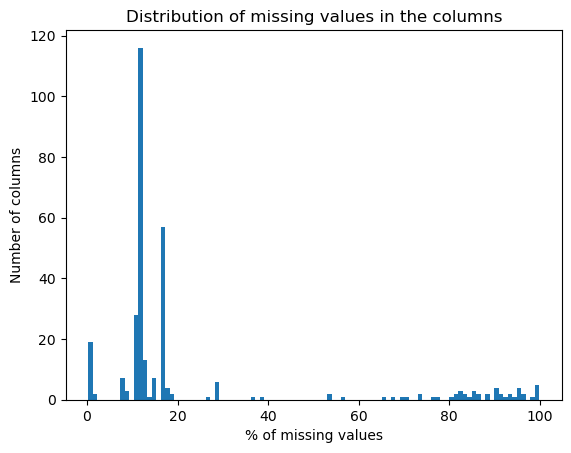

In [19]:
# Ploting the distribution of missing values per column
status = show_nans_distribution(df=azdias_cleaned, cols_or_rows=0)

From the above histogram, we can see that the vast majority of columns has no more than **30%** of missing values. Therefore, that value can be used as a cutoff for dropping the outlier columns.

In [20]:
def drop_outlier_columns(*, df_data: pd.DataFrame, cutoff: int = 0.5)-> Tuple[pd.DataFrame, int]:
    '''
    This function drops the columns from the dataframe having an amount of missing values greater than cutoff value.

    INPUT: df_data - dataframe whose columns may contain some missing values.
           cutoff  - limit value in % from which columns with higher % of missing values will be dropped.  
    OUTPUT: reduced dataframe with the dropped features.
            list with the names of the dropped features.
    '''

    # Calculating the percentage of missing values for each column
    series_nan_counts = df_data.isnull().mean(axis=0)

    # Getting the row names having a number of missing values greater than cutoff value 
    dropped_columns = list(series_nan_counts.loc[series_nan_counts > cutoff].index)

    # Dropping the columns matching the above selected row names
    df_reduced_data = df_data.drop(columns=dropped_columns)

    # Returning the reduced data frame in order to not modify the original one 
    return df_reduced_data, dropped_columns

In [21]:
azdias_cleaned, outlier_cols = drop_outlier_columns(df_data=azdias_cleaned, cutoff=0.3)
n_outlier_cols = len(outlier_cols)
print('Number of removed features: {} ({} %)'.format(n_outlier_cols, 100*n_outlier_cols/(len(azdias.columns))))
print('Removed features: ', outlier_cols)

Number of removed features: 51 (13.934426229508198 %)
Removed features:  ['AGER_TYP', 'AKT_DAT_KL', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'ANZ_KINDER', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_MOBILE', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_REST', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_VERSICHERUNGEN', 'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'VERDICHTUNGSRAUM', 'VHA']


#### Step 0.1.3: Assess Missing Data in Each Row
I'm gonna do a similar approach to detect and remove the outlier rows.

True

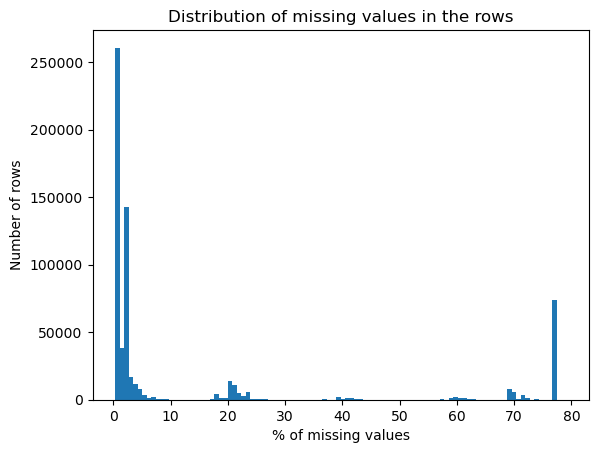

In [22]:
# Ploting the distribution of missing values per row
show_nans_distribution(df=azdias_cleaned, cols_or_rows=1)

From the above histogram, we can see that the vast majority of rows has no more than **30%** of missing values. Therefore, that value can be used as a cutoff for dropping the outlier rows.

In [23]:
def drop_outlier_rows(*, df: pd.DataFrame, cutoff: int = 0.5)-> Tuple[pd.DataFrame, int]:
    '''
    This function drops the rows from the dataframe having an amount of missing values greater than cutoff value.

    INPUT: df_data - dataframe whose rows may contain some missing values.
           cutoff  - limit value in % from which rows with higher % of missing values will be dropped.  
    OUTPUT: reduced dataframe with the dropped rows.
            integer standing for the number of dropped rows.
    '''
    
    df_clean = df.copy()

    # Calculating the percentage of missing values for each column
    df_clean['n_miss_vals'] = df_clean.isnull().mean(axis=1)

    # Calculating the number of rows to be removed
    n_removed_rows = sum(df_clean['n_miss_vals'] > cutoff)

    df_clean = df_clean.loc[df_clean['n_miss_vals'] <= cutoff]
    df_clean.drop(columns='n_miss_vals', inplace = True)
    
    return df_clean, n_removed_rows

In [24]:
azdias_cleaned, n_removed_rows = drop_outlier_rows(df=azdias_cleaned, cutoff=0.3)
print('Amount of removed rows: ', n_removed_rows)

Amount of removed rows:  105846


In [25]:
# Dropping the remaining missing features description
rem_mis_col_desc = mis_col_desc.difference(outlier_cols)
azdias_cleaned = azdias_cleaned.drop(columns=rem_mis_col_desc)
print('Additional removed features: ', rem_mis_col_desc)

Additional removed features:  {'D19_VERSI_ONLINE_DATUM', 'RT_SCHNAEPPCHEN', 'KOMBIALTER', 'LNR', 'KBA13_ANTG3', 'CJT_TYP_3', 'KBA13_KMH_210', 'KBA13_HHZ', 'KBA13_BAUMAX', 'KBA13_ANTG2', 'D19_KONSUMTYP_MAX', 'ANZ_STATISTISCHE_HAUSHALTE', 'RT_KEIN_ANREIZ', 'CJT_TYP_5', 'HH_DELTA_FLAG', 'CJT_TYP_2', 'KBA13_ANTG1', 'RT_UEBERGROESSE', 'VHN', 'KBA13_GBZ', 'MOBI_RASTER', 'STRUKTURTYP', 'D19_LETZTER_KAUF_BRANCHE', 'CJT_KATALOGNUTZER', 'EINGEFUEGT_AM', 'VK_DHT4A', 'SOHO_KZ', 'D19_VERSI_OFFLINE_DATUM', 'CJT_TYP_4', 'CJT_TYP_1', 'FIRMENDICHTE', 'EINGEZOGENAM_HH_JAHR', 'KBA13_ANTG4', 'DSL_FLAG', 'VK_DISTANZ', 'KBA13_CCM_1401_2500', 'GEMEINDETYP', 'UMFELD_ALT', 'UMFELD_JUNG', 'D19_VERSI_DATUM', 'VK_ZG11', 'CJT_TYP_6', 'UNGLEICHENN_FLAG', 'ARBEIT', 'KONSUMZELLE'}


### Step 0.2: Select and Re-Encode Features

Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, I will make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling is also necessary for the remaining two variable types: categorical, and mixed.

In the first two parts of this sub-step, I will conduct an investigation of the categorical and mixed-type features and make a decision on each of them, whether I will keep, drop, or re-encode each. Then, in the last part, I will create a new dataframe with only the selected and engineered columns.

In [26]:
valid_features = azdias_cleaned.columns.tolist()
valid_features_types = dias_att.loc[dias_att['Attribute'].isin(valid_features), ['Attribute', 'Type']]
valid_features_types['Type'].value_counts()

Type
ordinal        221
mixed           18
categorical     16
numeric         10
binary           4
interval         1
Name: count, dtype: int64

In [27]:
#astype('category') categorical
from pandas.api.types import CategoricalDtype
cat_dtype = CategoricalDtype(
    categories=[2, 1], ordered=True)

#### Step 0.2.1: Engineer Mixed-Type Features

In [28]:
# Exploring mixed features
mixed_feat = explore_feature_types(df_feat=azdias_cleaned, df_type=valid_features_types, feat_type='mixed')

CAMEO_INTL_2015 [51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0 nan
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45']
D19_BANKEN_DATUM [10  5  8  6  9  7  4  1  2  3]
D19_BANKEN_OFFLINE_DATUM [10  9  8  2  5  4  1  6  7  3]
D19_BANKEN_ONLINE_DATUM [10  5  8  6  9  4  7  1  2  3]
D19_GESAMT_DATUM [10  1  3  5  9  4  7  6  8  2]
D19_GESAMT_OFFLINE_DATUM [10  6  8  9  5  2  4  1  7  3]
D19_GESAMT_ONLINE_DATUM [10  1  3  5  9  4  7  6  8  2]
D19_TELKO_DATUM [10  6  9  8  5  7  4  2  1  3]
D19_TELKO_OFFLINE_DATUM [10  8  5  6  9  7  4  2  3  1]
D19_TELKO_ONLINE_DATUM [10  9  7  8  6  5  4  1  2  3]
D19_VERSAND_DATUM [10  1  5  9  4  8  6  3  2  7]
D19_VERSAND_OFFLINE_DATUM [10  9  6  8  5  2  1  4  7  3]
D19_VERSAND_ONLINE_DATUM [10  1  5  9  4  8  6  3  2  7]
LP_LEBENSPHASE_FEIN [21.  3.  0. 32.  8.  2.  5. 10.  4.  6. 23. 20.  1. 25. 13. 18. 31. 38.
 35. 30.  7. 22. 14. 29. 

LP_LEBENSPHASE_FEIN will be dropped from the analysis as it contains too many uncertainties for classifying their values into categorical variables INCOME, AGE and household occupation. D19_BANKEN_DATUM, D19_GESAMT_DATUM, D19_TELKO_DATUM and D19_VERSAND_DATUM will be also removed as their respective OFFLINE and ONLINE features are more specific.

In [29]:
def is_re_encoding_correct(*, df: pd.DataFrame, features: List[str], valid_values: Set[Union[str, int]]) -> None:
    '''
    This function checks if the given features are correctly re-enconded by comparing their unique values against  

    INPUT: 
        df (pandas dataframe) - dataframe holding the values of the features to be checked.
        features (string) - A list of strings with the names of the features held in the columns of df.  
        valid_values (set of either strings or integers) - A set of the allowable values for the given features
        
    OUTPUT: None.
    '''
    
    for feature in features:
        print(valid_values)
        #assert set(df[feature].dropna().unique()) == valid_values, "{} has values which are either not held in {} or lack of".format(feature, valid_values)
        assert set(df[feature].unique()) == valid_values, "{} has values which are either not held in {} or lack of".format(feature, valid_values)
        print('{} succesfully encoded into desired values!'.format(feature))

In [30]:
def create_new_feature_from_mixed_feature(*, df_feat: pd.DataFrame, df_type: pd.DataFrame, mix_feat: str, new_feat: str, map_vals: Dict[int, int], feat_type: str ='ordinal', cutoff: int = 0.5) -> bool:
    '''
    This function creates a new feature from a mixed-type feature given the mapping values dictionary provided that the amount
    of missing values is under the given cutoff threshold. 

    INPUT: 
        df_feat (pandas dataframe) - dataframe holding the mixed-type features.
        df_type (pandas dataframe) - dataframe holding the types of each feature.
        mix_feat (string) - The name of the mixed-type feature under study  
        new_feat (string) - The name to be given to the new feature
        valid_values (set of either strings or integers) - A set of the allowable values for the given features
        feat_type (string) - the feature type within the values 'binary', 'categorical' or 'ordinal' (default) 
        cutoff (integer) - The cutoff threshold applied for removing the outlier columns (default 0.5)
        
    OUTPUT: status of the feature creation (True: sucessful, False: failure)
    '''
    
    # Replacing the original values of the mixed-type feature with the desired ones
    df_feat[new_feat] = df_feat[mix_feat].replace(map_vals)
    
    # Checking that all values of the new feature are within the desired scale
    valid_values = set(map_vals.values()).difference({np.nan})
    print(valid_values)
    #is_re_encoding_correct(df=df_feat, features=[new_feat], valid_values=valid_values)
    
    # Checking if the new feature has missing values. If so, check if the portion of missing values does not trespass the 
    # given cutoff threshold for missing values in columns
    if df_feat[new_feat].isnull().sum() > 0:
        p_nulls = df_feat[new_feat].value_counts(normalize=True, dropna=False)[np.nan]
        
        if p_nulls > cutoff:
            print('The portion of missing values {} > {}. Therefore, the new feature will be dropped off from the dataframe'.format(p_nulls, cutoff))
            df_feat.drop(columns=new_feat, inplace = True)
            return df_type, False
    
    df_type = pd.concat([df_type, pd.DataFrame({'Attribute': [new_feat], 'Type': [feat_type]})], ignore_index=True)
    
    return df_type, True

In [31]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
print('PRAEGENDE_JUGENDJAHRE distinct values: ', np.sort(azdias_cleaned['PRAEGENDE_JUGENDJAHRE'].unique()))

PRAEGENDE_JUGENDJAHRE distinct values:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. nan]


In [32]:
# Engineer Binary variable movement: by looking at the meaning of each distinct value of PRAEGENDE_JUGENDJAHRE in the 
# DIAS Attributes - Values 2017.xlsx, I splitted the values into two groups, 0 - current movements and 1- new movements:
val_to_movement = {1: 0, 3: 0, 5: 0, 8: 0, 10: 0, 12: 0, 14: 0, 2: 1, 4: 1, 6: 1, 7: 1, 9: 1, 11: 1, 13: 1, 15: 1}
valid_features_types, re_eng_status = create_new_feature_from_mixed_feature(df_feat=azdias_cleaned,
                                      df_type=valid_features_types,
                                      feat_type="binary",
                                      mix_feat="PRAEGENDE_JUGENDJAHRE", 
                                      new_feat="PRAEGENDE_JUGENDJAHRE_MOVEMENT", 
                                      map_vals=val_to_movement, 
                                      cutoff=0.3)

{0, 1}


In [33]:
# Engineer interval-type variable decade: by looking at the meaning of each distinct value of PRAEGENDE_JUGENDJAHRE in the 
# DIAS Attributes - Values 2017.xlsx, I found out that the values onto one of the following decades 40, 50, 60, 70, 80, 90. 
# So, I create a dict mapping the values to their corresponding decade as follows:
val_to_dec = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90}
valid_features_types, re_eng_status = create_new_feature_from_mixed_feature(df_feat=azdias_cleaned,
                                                                            df_type=valid_features_types,
                                                                            mix_feat="PRAEGENDE_JUGENDJAHRE", 
                                                                            new_feat="PRAEGENDE_JUGENDJAHRE_DECADE", 
                                                                            map_vals=val_to_dec, 
                                                                            cutoff=0.3)

{70, 40, 80, 50, 90, 60}


In [34]:
# Investigate "CAMEO_INTL_2015"
print('CAMEO_INTL_2015 distinct values: ', azdias_cleaned['CAMEO_INTL_2015'].unique())

CAMEO_INTL_2015 distinct values:  [51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0 nan
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45']


In [35]:
# Convertig all values to strings for later preprocessing
azdias_cleaned['CAMEO_INTL_2015'] = azdias_cleaned['CAMEO_INTL_2015'].astype('str').str.replace(".0", "")
print('CAMEO_INTL_2015 distinct values: ', np.sort(azdias_cleaned['CAMEO_INTL_2015'].unique()))

CAMEO_INTL_2015 distinct values:  ['12' '13' '14' '15' '22' '23' '24' '25' '31' '32' '33' '34' '35' '41'
 '43' '44' '45' '51' '52' '54' '55' 'nan']


Engineer the two new variables, wealth and life stage: By looking at the meaning of each distinct value of CAMEO_INTL_2015 in the DIAS Attributes - Values 2017.xlsx, I found out that the first digit of each value corresponds to the wealth status, whereas the second one do so to life stage.

In [36]:
# Wealth: 1 - Wealthy, 2 - Prosperous, 3 - Comfortable, 4 - Less affluent, 5 - Poorer
val_to_wealth = {val: int(val[0]) if val not in 'nan' else np.nan 
                 for val in np.sort(azdias_cleaned['CAMEO_INTL_2015'].unique())}

valid_features_types, re_eng_status = create_new_feature_from_mixed_feature(df_feat=azdias_cleaned,
                                      df_type=valid_features_types,
                                      mix_feat="CAMEO_INTL_2015", 
                                      new_feat="CAMEO_INTL_2015_WEALTH", 
                                      map_vals=val_to_wealth, 
                                      cutoff=0.3)

{1, 2, 3, 4, 5}


In [37]:
# Life Stage: 
# 1 - Singles, 2 - Young with children, 3 - School age children, 4 - Older families & mature couples, 5 - Elders in retirement
val_to_life_stage = {val: int(val[1]) if val not in 'nan' else np.nan 
                     for val in np.sort(azdias_cleaned['CAMEO_INTL_2015'].unique())}

valid_features_types, re_eng_status =  create_new_feature_from_mixed_feature(df_feat=azdias_cleaned,
                                      df_type=valid_features_types,
                                      mix_feat="CAMEO_INTL_2015", 
                                      new_feat="CAMEO_INTL_2015_LIFE_STAGE", 
                                      map_vals=val_to_life_stage, 
                                      cutoff=0.3)

{1, 2, 3, 4, 5}


In [38]:
# Investigate "WOHNLAGE" and engineer two new variables.
print('WOHNLAGE distinct values: ', np.sort(azdias_cleaned['WOHNLAGE'].unique()))

WOHNLAGE distinct values:  [0. 1. 2. 3. 4. 5. 7. 8.]


In [39]:
# Engineer the two new variables, neighbourhood quality and neighbourhood type: By looking at the meaning of each distinct value 
# of WOHNLAGE in the DIAS Attributes - Values 2017.xlsx, I found out that Neighbourhood quality can be split into 5 possibilities: 
# 0 - very poor, 1- poor, 2 - average, 3- good, 4 - very good
valid_features_types, re_eng_status = create_new_feature_from_mixed_feature(df_feat=azdias_cleaned,
                                      df_type=valid_features_types,
                                      mix_feat="WOHNLAGE", 
                                      new_feat="WOHNLAGE_NEIGHBOURHOOD_QUALITY", 
                                      map_vals={0: np.nan, 1: 4, 2: 3, 3: 2, 4: 1, 5: 0, 7: np.nan, 8: np.nan}, 
                                      cutoff=0.3)

{0, 1, 2, 3, 4}


We can see that the portion of missing values is **less** than the cutoff threshold of **30%** (i.e., **24%**)

In [40]:
# Now feature for neighbourhood_type as 0-rural, 1-urban
valid_features_types, re_eng_status = create_new_feature_from_mixed_feature(df_feat=azdias_cleaned,
                                      df_type=valid_features_types,
                                      feat_type="binary",                                      
                                      mix_feat="WOHNLAGE", 
                                      new_feat="WOHNLAGE_NEIGHBOURHOOD_TYPE", 
                                      map_vals={0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 7: 0, 8: 0}, 
                                      cutoff=0.3)

{0, 1}


In [41]:
# Investigate "PLZ8_BAUMAX" and engineer two new variables.
print('PLZ8_BAUMAX distinct values: ', np.sort(azdias_cleaned['PLZ8_BAUMAX'].unique()))

PLZ8_BAUMAX distinct values:  [ 1.  2.  3.  4.  5. nan]


In [42]:
# Engineer the two new variables, n_family_homes and building_type: By looking at the meaning of each distinct value 
# of PLZ8_BAUMAX in the DIAS Attributes - Values 2017.xlsx, I found out that can be split into 5 possibilities: 
# 0 - No family homes, 1- 1-2 family homes, 2 - 3-5 family homes, 3- 6-10 family homes, 4 - > 10 family homes 
valid_features_types, re_eng_status = create_new_feature_from_mixed_feature(df_feat=azdias_cleaned,
                                      df_type=valid_features_types,
                                      mix_feat="PLZ8_BAUMAX", 
                                      new_feat="PLZ8_BAUMAX_N_FAMILY_HOMES", 
                                      map_vals={1: 1, 2: 2, 3: 3, 4: 4, 5: 0}, 
                                      cutoff=0.3)

{0, 1, 2, 3, 4}


In [43]:
# Now feature for building_type as 0-family home, 1-business building
valid_features_types, re_eng_status = create_new_feature_from_mixed_feature(df_feat=azdias_cleaned,
                                      df_type=valid_features_types,
                                      feat_type="binary",
                                      mix_feat="PLZ8_BAUMAX", 
                                      new_feat="PLZ8_BAUMAX_BUILDING_TYPE", 
                                      map_vals={1: 0, 2: 0, 3: 0, 4: 0, 5: 1}, 
                                      cutoff=0.3)

{0, 1}


In [44]:
# Investigate "LP_LEBENSPHASE_GROB" and engineer three new variables.
print('LP_LEBENSPHASE_GROB distinct values: ', np.sort(azdias_cleaned['LP_LEBENSPHASE_GROB'].unique()))

LP_LEBENSPHASE_GROB distinct values:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. nan]


In [45]:
# Income level: 0 - Low and Average, 1 - Average, 2 - High
valid_features_types, re_eng_status = create_new_feature_from_mixed_feature(df_feat=azdias_cleaned,
                                      df_type=valid_features_types,
                                      feat_type="categorical",
                                      mix_feat="LP_LEBENSPHASE_GROB", 
                                      new_feat="LP_LEBENSPHASE_GROB_INCOME", 
                                      map_vals={1: 0, 2: 0, 3: 2, 4: 0, 5: 2, 6: np.nan, 7: 0, 8: 2, 9: 1, 10: 0, 11: 2, 12: 2}, 
                                      cutoff=0.3)

{0, 1, 2}


In [46]:
# Age: 0 - young, 1 - high  
create_new_feature_from_mixed_feature(df_feat=azdias_cleaned,
                                      df_type=valid_features_types,
                                      mix_feat="LP_LEBENSPHASE_GROB", 
                                      new_feat="LP_LEBENSPHASE_GROB_AGE", 
                                      map_vals={1: 0, 2: 1, 3: np.nan, 4: np.nan, 5: np.nan, 6: np.nan, 7: np.nan, 8: np.nan, 9: 0, 10: 1, 11: 0, 12: 1}, 
                                      cutoff=0.3)

{0, 1}
The portion of missing values 0.41477765398694894 > 0.3. Therefore, the new feature will be dropped off from the dataframe


(                          Attribute         Type
 0              ALTERSKATEGORIE_GROB      ordinal
 1                          ALTER_HH     interval
 2                         ANREDE_KZ       binary
 3               ANZ_HAUSHALTE_AKTIV      numeric
 4                      ANZ_HH_TITEL      numeric
 ..                              ...          ...
 274  WOHNLAGE_NEIGHBOURHOOD_QUALITY      ordinal
 275     WOHNLAGE_NEIGHBOURHOOD_TYPE       binary
 276      PLZ8_BAUMAX_N_FAMILY_HOMES      ordinal
 277       PLZ8_BAUMAX_BUILDING_TYPE       binary
 278      LP_LEBENSPHASE_GROB_INCOME  categorical
 
 [279 rows x 2 columns],
 False)

In [47]:
# household occupation: 0-single, 1-single parents, 2-single and couples, 3-single and family, 4-family, 5-multiperson  
valid_features_types, re_eng_status = create_new_feature_from_mixed_feature(df_feat=azdias_cleaned,
                                      df_type=valid_features_types,
                                      feat_type='categorical',                                             
                                      mix_feat="LP_LEBENSPHASE_GROB", 
                                      new_feat="LP_LEBENSPHASE_GROB_HH_OCC", 
                                      map_vals={1: 0, 2: 0, 3: 0, 4: 2, 5: 2, 6: 1, 7: 3, 8: 4, 9: 5, 10: 5, 11: 5, 12: 5}, 
                                      cutoff=0.3)

{0, 1, 2, 3, 4, 5}


In [48]:
# Investigate 'D19_BANKEN_DATUM' and engineer two new variables: 'D19_BANKEN_DATUM_ACTIVITY_TIME' and 
# 'D19_BANKEN_DATUM_ACTIVITY_LEVEL'.
DATUM_COLS = ['D19_BANKEN_OFFLINE_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM']
#print('D19_BANKEN_DATUM: ', np.sort(red_azdias_mix_reeng['D19_BANKEN_DATUM'].unique()))

In [49]:
# ACTIVITY_TIME 
# 0 - Never, 1 - Less than a year, 2 - More than a year, 3 - More than 1.5 years, 4 - More than 2 years, 5 - More than 3 years
val_to_time = {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 2, 7: 3, 8: 4, 9: 5, 10: 0}
for datum_col in DATUM_COLS:
    valid_features_types, re_eng_status = create_new_feature_from_mixed_feature(df_feat=azdias_cleaned,
                                          df_type=valid_features_types,
                                          mix_feat=datum_col, 
                                          new_feat=datum_col + "_ACTIVITY_TIME", 
                                          map_vals=val_to_time, 
                                          cutoff=0.3)

{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3, 4, 5}


In [50]:
# ACTIVITY_LEVEL
# 0 - None, 1 - extremely low, 2 - very low, 3 - low, 4 - moderately low, 5 - slightly low
# 6 - slightly high, 7 - moderately high, 8 - high, 9 - very high
val_to_level = {1: 7, 2: 9, 3: 8, 4: 6, 5: 5, 6: 4, 7: 3, 8: 2, 9: 1, 10: 0}
for datum_col in DATUM_COLS:
    valid_features_types, re_eng_status = create_new_feature_from_mixed_feature(df_feat=azdias_cleaned,
                                          df_type=valid_features_types,
                                          mix_feat=datum_col, 
                                          new_feat=datum_col + "_ACTIVITY_LEVEL", 
                                          map_vals=val_to_level, 
                                          cutoff=0.3)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [51]:
# Removing the mixed-type features
azdias_cleaned.drop(columns=mixed_feat, inplace=True)

#### Step 0.2.2: Curse of dimensionality

As the number of categories grows, the amount of data needed to accurately distinguish among the features (in order to give us a prediction) and generalize our model (learned function) grows exponentially [[2]](https://towardsdatascience.com/dealing-with-features-that-have-high-cardinality-1c9212d7ff1b). To reduce the cardinality of a feature, I will adapt the method shown in [[1]](https://www.quora.com/What-is-the-curse-of-dimensionality) to consider missing values as an additional category and to process all categorical features at once. So, for each categorical feature, the idea is to leave categories belonging to a value with high frequency as they are and replace the others with a new category labelled as 'other'.

The main steps to carry out for each categorical feature are as follows:

1. Choose a cutoff threshold (i.e., 75% by default)
2. Turn missing values into a new category labelled as 'nan'
3. Sort unique values in the feature by their frequency in descending order
4. Keep adding the frequency of these sorted (descending) unique values until a threshold is reached.

Let’s run through a quick example before applying the method below. Say our feature 'colour' has 100 values and our cutoff threshold is 90%. We have 5 different categories of colours: Red (50), Blue(40), Yellow (5), Green (3) and Orange (2). The numbers within the bracket indicate how many instances of that category are present in the column. We see that Red (50) + Blue (40) reaches our threshold of 90. In that case, we retain only 2 categories (Red, Blue) and mark all other instances of other colours as “Other”.

In [52]:
def reduce_cat_dim(*, features: List[str], df_feat: pd.DataFrame, df_type: pd.DataFrame, cutoff: float = 0.75) -> Tuple[pd.DataFrame, pd.DataFrame, dict]:
    '''
    This function treats the curse of dimensionality by searching for low amounts of categories and replacing them with one
    grouping category 'others'

    INPUT: 
        features (list of strings) - The names of the features to be analyzed.
        df_feat (pandas dataframe) - dataframe holding the values of each feature.
        df_type (pandas dataframe) - dataframe holding the types of each feature.
        cutoff (float) - Threshold value for identifying the low amount of categories.  
    
    OUTPUT: 
        dataframe holding the transformed values of each feature
        dataframe holding the changed types from categorical to binary of some features
    '''  
    
    new_df_feat = df_feat.copy()
    new_df_type = df_type.copy()
    feat_to_group = dict()
    
    for feature in features:
        print('{}'.format(feature))
    
        # Drop missing values from the analysis
        feat_vals = new_df_feat[feature].replace({np.nan: 'nan'})
        
        # Find the threshold value using the percentage and number of instances in the column
        cutoff_value = int(cutoff*len(feat_vals))
    
        # Initialise to nan the list for our new minimised categories
        categories_list = list()
    
        # Initialise a variable to calculate the sum of frequencies
        acc_sum = 0
    
        # Create a counter dictionary of the form unique_value: frequency
        counts = Counter(feat_vals)
        
        # Loop through the category name and its corresponding frequency after sorting the categories by descending order of 
        # frequency 
        for i, j in counts.most_common():
        
            # Add the frequency to the global sum
            acc_sum += dict(counts)[i]
    
            # Append the category name to the list
            categories_list.append(i)
        
            # Check if the global sum has reached the threshold value, if so break the loop 
            if acc_sum >= cutoff_value:      
                feat_to_group[feature] = set(counts.keys()).difference(categories_list)
                
            
                # Replace all instances not in our new categories by 'Other'
                new_df_feat[feature].replace(feat_to_group[feature], 'Other', inplace=True)
                print('Before: {}\n After: {}\n'.format(df_feat[feature].unique(), new_df_feat[feature].unique()))
                
                new_df_feat[feature].replace({'nan': np.nan}, inplace=True)
            
                # Check if after the grouping, the feature has only two categories. If so, set its type as binary 
                if new_df_feat[feature].dropna().nunique() == 2:
                    new_df_type.loc[new_df_type['Attribute'] == feature, 'Type'] = 'binary'
                    
                break
           
    
    # Return transformed dataframe
    return new_df_feat, new_df_type, feat_to_group

In [53]:
# Call the function with a default threshold of 75%
features = valid_features_types.loc[valid_features_types['Type'] == 'categorical', 'Attribute'].to_list()
azdias_cleaned, valid_features_types, feat_to_group  = reduce_cat_dim(features=features, df_feat=azdias_cleaned, df_type=valid_features_types)

CAMEO_DEUG_2015
Before: [8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 nan '4' '3' '7' '2' '8' '9' '6' '5'
 '1']
 After: [8.0 4.0 'Other' 6.0 9.0 3.0 nan '4' '3' '7' '2' '8' '9' '6']

CAMEO_DEU_2015
Before: ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '7A' '5D' '9E'
 '9B' '1B' '8B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']
 After: ['8A' '4C' 'Other' '6B' '8C' '4A' '2D' '9D' '7A' '5D' '9B' '8B' '3D' nan
 '3C' '7B' '9A' '6E' '2C' '9C' '8D' '2B']

CJT_GESAMTTYP
Before: [ 5.  3.  2.  4.  1.  6. nan]
 After: [5.0 3.0 2.0 4.0 'Other' 6.0 nan]

D19_KONSUMTYP
Before: [nan  9.  1.  4.  3.  6.  5.  2.]
 After: [nan 9.0 1.0 4.0 'Other']

FINANZTYP
Before: [1 6 5 2 4 3]
 After: [1 6 5 2 'Other']

GEBAEUDETYP
Before: [8. 1. 3. 2. 6. 4. 5.]
 After: ['Other' 1.0 3.0]

GFK_URLAUBERTYP
Before: [10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6. nan]
 After: [10.0 'Other' 5.0 12.0 9.0 3.0 8.0 11.0 4.0 nan]


In [54]:
for feat, vals_to_group in feat_to_group.items():
    print("'{}': {}".format(feat, vals_to_group))

'CAMEO_DEUG_2015': {1.0, 2.0, 5.0, 7.0, '5', '1', 'nan'}
'CAMEO_DEU_2015': {'5A', '4D', '7D', '5E', '6F', '1B', '5F', '6C', '4B', '1A', '6D', '4E', '5C', '5B', '3B', '6A', '2A', '1D', '3A', '1E', '7C', '9E', '7E', '1C', 'nan'}
'CJT_GESAMTTYP': {1.0, 'nan'}
'D19_KONSUMTYP': {2.0, 3.0, 5.0, 6.0}
'FINANZTYP': {3, 4}
'GEBAEUDETYP': {2.0, 4.0, 5.0, 6.0, 8.0}
'GFK_URLAUBERTYP': {1.0, 2.0, 6.0, 7.0, 'nan'}
'KBA05_MAXHERST': {1.0, 5.0, 'nan'}
'KBA05_SEG6': {1.0, 'nan'}
'LP_FAMILIE_FEIN': {0.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 11.0, 'nan'}
'LP_FAMILIE_GROB': {0.0, 3.0, 4.0, 'nan'}
'LP_STATUS_FEIN': {3.0, 5.0, 6.0, 7.0, 8.0, 'nan'}
'LP_STATUS_GROB': {3.0, 5.0, 'nan'}
'NATIONALITAET_KZ': {2.0, 3.0, 'nan'}
'SHOPPER_TYP': {0.0, 'nan'}
'ZABEOTYP': {2, 5, 6}
'LP_LEBENSPHASE_GROB_INCOME': {1.0, 'nan'}
'LP_LEBENSPHASE_GROB_HH_OCC': {1.0, 3.0, 4.0, 'nan'}


#### Step 0.2.3: Re-Encode Categorical Features

Each level of the categorical features needs to be encoded as a dummy variable  (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)). Depending on the number of categories, the following encodings will be performed:
- Two-level or binary categorical features taking
    - numeric values will be kept as they are but their nan-values will be enconded as a new dummy variable 
    - non-numeric values will be re-encoded as 0-1 values and their nan-values will be enconded as a new dummy variable too.
- Multi-level categorical features (>=3) will be either encoded using multiple dummy variables or dropped from the analysis.

In [55]:
# Exploring the categorical features       
categorical_feat = explore_feature_types(df_feat=azdias_cleaned, df_type=valid_features_types, feat_type='categorical')

CAMEO_DEUG_2015 [8.0 4.0 'Other' 6.0 9.0 3.0 nan '4' '3' '7' '2' '8' '9' '6']
CAMEO_DEU_2015 ['8A' '4C' 'Other' '6B' '8C' '4A' '2D' '9D' '7A' '5D' '9B' '8B' '3D' nan
 '3C' '7B' '9A' '6E' '2C' '9C' '8D' '2B']
CJT_GESAMTTYP [5.0 3.0 2.0 4.0 'Other' 6.0 nan]
D19_KONSUMTYP [nan 9.0 1.0 4.0 'Other']
FINANZTYP [1 6 5 2 'Other']
GEBAEUDETYP ['Other' 1.0 3.0]
GFK_URLAUBERTYP [10.0 'Other' 5.0 12.0 9.0 3.0 8.0 11.0 4.0 nan]
KBA05_MAXHERST [2.0 'Other' 3.0 nan 4.0]
LP_FAMILIE_FEIN ['Other' 1.0 10.0 2.0 nan]
LP_FAMILIE_GROB ['Other' 1.0 5.0 2.0 nan]
LP_STATUS_FEIN [2.0 'Other' 9.0 4.0 1.0 10.0 nan]
LP_STATUS_GROB [1.0 2.0 4.0 'Other' nan]
SHOPPER_TYP [3.0 2.0 1.0 'Other' nan]
ZABEOTYP ['Other' 3 4 1]
LP_LEBENSPHASE_GROB_INCOME [nan 0.0 2.0 'Other']
LP_LEBENSPHASE_GROB_HH_OCC ['Other' 0.0 nan 5.0 2.0]


I decided to drop CAMEO_DEUG_2015, LP_STATUS_GROB, LP_FAMILIE_GROB as we have more specific variables accounting for them in CAMEO_DEU_2015, LP_STATUS_FEIN, LP_FAMILIE_FEIN.

In [56]:
# Preliminar steps to re-encode categorical feature(s) to be kept in the analysis.

# Drop categorial features that are copies of other more specific ones
rem_categorical_feat = {'CAMEO_DEUG_2015', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB'}
kept_categorical_feat = list(set(categorical_feat).difference(rem_categorical_feat))
azdias_cleaned.drop(columns=rem_categorical_feat, inplace = True)

rem_groups = rem_categorical_feat.intersection(feat_to_group)
for group in rem_groups:
    feat_to_group.pop(group)

print('Categorical features to kept: ', kept_categorical_feat)    
    
# Re-encoding the categorical features to kept in the analysis.
azdias_cleaned = pd.get_dummies(azdias_cleaned, columns=kept_categorical_feat, dummy_na = DUMMY_NA)
print(azdias_cleaned.head(5))

Categorical features to kept:  ['CAMEO_DEU_2015', 'LP_STATUS_FEIN', 'FINANZTYP', 'CJT_GESAMTTYP', 'D19_KONSUMTYP', 'GFK_URLAUBERTYP', 'KBA05_MAXHERST', 'LP_LEBENSPHASE_GROB_HH_OCC', 'LP_LEBENSPHASE_GROB_INCOME', 'GEBAEUDETYP', 'SHOPPER_TYP', 'ZABEOTYP', 'LP_FAMILIE_FEIN']
   ALTER_HH  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL  ...  \
1       0.0                 11.0           0.0           2.0        0.0  ...   
2      17.0                 10.0           0.0           1.0        0.0  ...   
3      13.0                  1.0           0.0           0.0        0.0  ...   
4      20.0                  3.0           0.0           4.0        0.0  ...   
5      10.0                  5.0           0.0           1.0        0.0  ...   

   ZABEOTYP_Other  LP_FAMILIE_FEIN_1.0  LP_FAMILIE_FEIN_2.0  \
1            True                False                False   
2            True                 True                False   
3           False                False                Fal

#### Re-encodings in binary variables
We have to change the 'other' values with either 0 or 1 in all categorical features having been turn into binary in the grouped their categories with less than 25 % of values into 'other' category, were. Moreover, variables ANREDE_KZ and VERS_TYP require to change values 2 with 0. Regarding to variable OST_WEST_KZ, the letters 'W' and 'O' needs to be encoded as 0 and 1 values. Finally, a dummy variable needs to be created to account for the presence of nan values in VERS_TYP.

In [57]:
# Exploring the binary features       
binary_feat = explore_feature_types(df_feat=azdias_cleaned, df_type=valid_features_types, feat_type='binary')

ANREDE_KZ [2 1]
GREEN_AVANTGARDE [0 1]
KBA05_SEG6 ['Other' 0.0 nan]
NATIONALITAET_KZ [1.0 'Other' nan]
OST_WEST_KZ ['W' 'O']
VERS_TYP [ 2.  1. nan]
PRAEGENDE_JUGENDJAHRE_MOVEMENT [ 0.  1. nan]
WOHNLAGE_NEIGHBOURHOOD_TYPE [1. 0.]
PLZ8_BAUMAX_BUILDING_TYPE [ 0.  1. nan]


In [58]:
azdias_cleaned['ANREDE_KZ'].replace({2: 0}, inplace = True)
azdias_cleaned['OST_WEST_KZ'].replace({'W': 0, 'O': 1}, inplace = True)
azdias_cleaned['NATIONALITAET_KZ'].replace({'Other': 0}, inplace = True)
azdias_cleaned['KBA05_SEG6'].replace({'Other': 1, 0.0: 0}, inplace = True)
azdias_cleaned['VERS_TYP'].replace({1: 0, 2: 1}, inplace = True)

In [59]:
# We check that all variables are within 0 and 1
binary_features = valid_features_types.loc[valid_features_types['Type'] == 'binary', 'Attribute'].tolist()

In [60]:
fill_operators = {'numeric': 'median', 
                  'ordinal': 'mode',
                  'interval': 'mode',
                  'binary': 'mode'}

# Filling missing values in colums according to the specified fill_operator
for feat_type in fill_operators:
    num_feat = valid_features_types.loc[valid_features_types['Type'] == feat_type, 'Attribute'].tolist()
    for col in num_feat:
        if fill_operators[feat_type] == 'mode':
            azdias_cleaned[col].fillna((azdias_cleaned[col].mode()[0]), inplace=True)
        elif fill_operators[feat_type] == 'median':
            azdias_cleaned[col].fillna((azdias_cleaned[col].median()), inplace=True)
        elif fill_operators[feat_type] == 'constant':
            azdias_cleaned[col].fillna(fill_value, inplace=True)
        else:
            print('Fill method {} is not available'.format(fill_operator))
            exit(-1)

In [61]:
# Test that all missing values have been filled out
n_miss_vals = azdias_cleaned.isnull().sum().sum()
assert n_miss_vals == 0, "There are still {} missing values".format(n_miss_vals)
print('There no missing values, which is great!')

There no missing values, which is great!


### Step 0.3: Create a Cleaning Function

Even though we've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that we'll need to perform the same cleaning steps on the customer demographics data. In this substep, I'm going to complete the function below to execute the main feature selection, encoding, and re-engineering steps I performed above. Then, I will run this function on the general population again to check that I get the same output and, finally, I will apply to the customers data.

In [62]:
def clean_data(*, df_feat: pd.DataFrame, df_mu: pd.DataFrame, valid_features_types: pd.DataFrame, dummy_na: bool = False) -> pd.DataFrame:
    """
    This method performs all the necessary cleaning operations on the given dataset. The main steps are:
    1. Dropping the columns with highest amount of missing values
    2. Dropping the remaining rows with highest amount of missing values
    3. Re-encoding the mixed-type features into new ordinal/categorical features
    4. Reducing the cardinality of the categorical features having categories with low density
    5. Setting up the binary features by turning them into 0-1 values
    6. Filling out the remaining missing values 
    
    INPUT: 
        df_feat (dataframe) dataset holding the features
        df_mu (dataframe) dataset holding the categories representing missing values for each feature
        valid_features_types (dataframe) dataset with the types of each feature
        dummy_na (boolean) indicates whether to consider the missing values of the categorical variables as dummy variables
    
    OUTPUT:
        dataframe holding the data cleaned from df_feat     
    """
    
    # Identifying missing or unknown data values and convert them to NaNs.
    df_cleaned = replace_missing_unknown_with_nan(df_data=df_feat, df_mu=df_mu)

    outlier_cols = ['AGER_TYP', 'AKT_DAT_KL', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 
                    'ALTERSKATEGORIE_FEIN', 'ANZ_KINDER', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 
                    'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 
                    'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 
                    'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO', 
                    'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 
                    'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_MOBILE', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_REST', 
                    'D19_TIERARTIKEL', 'D19_VERSAND_REST', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_VERSICHERUNGEN', 
                    'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 
                    'VERDICHTUNGSRAUM', 'VHA']
    
    # Remove outlier columns
    df_cleaned.drop(columns=outlier_cols, inplace=True)

    # Remove outlier rows
    df_cleaned['n_miss_vals'] = df_cleaned.isnull().mean(axis=1)
    df_cleaned = df_cleaned.loc[df_cleaned['n_miss_vals'] <= 0.3].drop(columns = 'n_miss_vals')
    
    # Re-engineering mixed-type features
    df_cleaned['CAMEO_INTL_2015'] = df_cleaned['CAMEO_INTL_2015'].astype('str').str.replace(".0", "")
    val_to_wealth = {val: int(val[0]) if val not in 'nan' else np.nan 
                     for val in np.sort(df_cleaned['CAMEO_INTL_2015'].unique())}        

    val_to_life_stage = {val: int(val[1]) if val not in 'nan' else np.nan 
                         for val in np.sort(df_cleaned['CAMEO_INTL_2015'].unique())}

    map_vals = {'PRAEGENDE_JUGENDJAHRE': {'PRAEGENDE_JUGENDJAHRE_MOVEMENT': {1: 0, 3: 0, 5: 0, 8: 0, 10: 0, 12: 0, 14: 0, 2: 1, 4: 1, 6: 1, 7: 1, 9: 1, 11: 1, 13: 1, 15: 1}, 
                                          'PRAEGENDE_JUGENDJAHRE_DECADE': {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90}},
            
                'CAMEO_INTL_2015': {'CAMEO_INTL_2015_WEALTH': val_to_wealth,
                                    'CAMEO_INTL_2015_LIFE_STAGE': val_to_life_stage},
            
                'WOHNLAGE': {'WOHNLAGE_NEIGHBOURHOOD_QUALITY': {0: np.nan, 1: 4, 2: 3, 3: 2, 4: 1, 5: 0, 7: np.nan, 8: np.nan},
                             'WOHNLAGE_NEIGHBOURHOOD_TYPE': {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 7: 0, 8: 0}},
            
                'PLZ8_BAUMAX': {'PLZ8_BAUMAX_N_FAMILY_HOMES': {1: 1, 2: 2, 3: 3, 4: 4, 5: 0},
                                'PLZ8_BAUMAX_BUILDING_TYPE': {1: 0, 2: 0, 3: 0, 4: 0, 5: 1}},
            
                'LP_LEBENSPHASE_GROB': {'LP_LEBENSPHASE_GROB_INCOME': {1: 0, 2: 0, 3: 2, 4: 0, 5: 2, 6: np.nan, 7: 0, 8: 2, 9: 1, 10: 0, 11: 2, 12: 2},
                                        'LP_LEBENSPHASE_GROB_HH_OCC': {1: 0, 2: 0, 3: 0, 4: 2, 5: 2, 6: 1, 7: 3, 8: 4, 9: 5, 10: 5, 11: 5, 12: 5}}
               } 
    
    # Replacing the original values of the mixed-type feature with the desired ones    
    for mixed_feat in map_vals:
        for eng_feat, val_to_val in map_vals[mixed_feat].items():
            df_cleaned[eng_feat] = df_cleaned[mixed_feat].replace(val_to_val)

        
    DATUM_COLS = ['D19_BANKEN_OFFLINE_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 
                  'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM']

    d19_eng_feats_vals = {'_ACTIVITY_LEVEL': {1: 7, 2: 9, 3: 8, 4: 6, 5: 5, 6: 4, 7: 3, 8: 2, 9: 1, 10: 0},
                          '_ACTIVITY_TIME': {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 2, 7: 3, 8: 4, 9: 5, 10: 0}}

    for datum_col in DATUM_COLS:
        for eng_feat, val_to_val in d19_eng_feats_vals.items():
        
            # Replacing the original values of the mixed-type feature with the desired ones
            df_cleaned[datum_col + eng_feat] = df_cleaned[datum_col].replace(val_to_val)

    # Removing the rest of features: unuseful and mixed-type re-encoded
    unuseful_feat = ['ANZ_STATISTISCHE_HAUSHALTE', 'GEMEINDETYP', 'CJT_KATALOGNUTZER', 'KBA13_BAUMAX', 'VHN', 'EINGEFUEGT_AM', 
                     'VK_DISTANZ', 'VK_ZG11', 'KOMBIALTER', 'KBA13_ANTG1', 'RT_SCHNAEPPCHEN', 'KBA13_GBZ', 'KONSUMZELLE', 
                     'KBA13_ANTG2', 'LNR', 'HH_DELTA_FLAG', 'CJT_TYP_3', 'D19_KONSUMTYP_MAX', 'D19_VERSI_DATUM', 
                     'UNGLEICHENN_FLAG', 'CJT_TYP_4', 'KBA13_ANTG4', 'D19_VERSI_ONLINE_DATUM', 'UMFELD_JUNG', 
                     'RT_KEIN_ANREIZ', 'CJT_TYP_6', 'DSL_FLAG', 'CJT_TYP_5', 'EINGEZOGENAM_HH_JAHR', 'VK_DHT4A', 
                     'D19_LETZTER_KAUF_BRANCHE', 'D19_VERSI_OFFLINE_DATUM', 'KBA13_KMH_210', 'CJT_TYP_1', 'STRUKTURTYP', 
                     'KBA13_HHZ', 'RT_UEBERGROESSE', 'SOHO_KZ', 'KBA13_CCM_1401_2500', 'CJT_TYP_2', 'ARBEIT', 'UMFELD_ALT', 
                     'MOBI_RASTER', 'KBA13_ANTG3', 'FIRMENDICHTE', 'LP_LEBENSPHASE_FEIN', 'CAMEO_DEUG_2015', 'LP_STATUS_GROB', 
                     'LP_FAMILIE_GROB', 'D19_BANKEN_DATUM', 'D19_GESAMT_DATUM', 'D19_TELKO_DATUM', 'D19_VERSAND_DATUM']
    
    df_cleaned.drop(columns=list(map_vals) + DATUM_COLS + unuseful_feat, inplace=True)
    
    # Grouping low density categories of given features into 'others' category
    feat_to_group = {'CAMEO_DEU_2015': {'3B', '5A', '7D', '5E', '6F', '1A', '1B', '6D', '6C', '1C', '3A', '5C', '7E', '2A', '1E', '4E', '5B', '9E', 'nan', '4D', '4B', '5F', '7C', '1D', '6A'},
                     'CJT_GESAMTTYP': {1.0, np.nan},
                     'D19_KONSUMTYP': {2.0, 3.0, 5.0, 6.0},
                     'FINANZTYP': {3, 4},
                     'GEBAEUDETYP': {2.0, 4.0, 5.0, 6.0, 8.0},
                     'GFK_URLAUBERTYP': {1.0, 2.0, 6.0, 7.0, np.nan},
                     'KBA05_MAXHERST': {1.0, 5.0, np.nan},
                     'KBA05_SEG6': {1.0, np.nan},
                     'LP_FAMILIE_FEIN': {0.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 11.0, np.nan},
                     'LP_STATUS_FEIN': {3.0, 5.0, 6.0, 7.0, 8.0, np.nan},
                     'NATIONALITAET_KZ': {np.nan, 2.0, 3.0},
                     'SHOPPER_TYP': {0.0, np.nan},
                     'ZABEOTYP': {2, 5, 6},
                     'LP_LEBENSPHASE_GROB_INCOME': {np.nan, 1.0},
                     'LP_LEBENSPHASE_GROB_HH_OCC': {1.0, 3.0, 4.0, np.nan}}
    
    for feat, grouped_cat in feat_to_group.items():
        df_cleaned[feat].replace(grouped_cat, 'Other', inplace = True)

    # Re-encoding the categorical features to kept in the analysis and retaining missing values after one-hot encoding 
    # if required
    cat_feats_to_one_hot_encoding = ['LP_FAMILIE_FEIN', 'SHOPPER_TYP', 'GEBAEUDETYP', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015', 
                                     'LP_LEBENSPHASE_GROB_INCOME', 'GFK_URLAUBERTYP', 'CJT_GESAMTTYP', 'KBA05_MAXHERST', 
                                     'D19_KONSUMTYP', 'LP_LEBENSPHASE_GROB_HH_OCC', 'FINANZTYP', 'ZABEOTYP']
    
    df_cleaned = pd.get_dummies(df_cleaned, columns=cat_feats_to_one_hot_encoding, dummy_na=dummy_na)
    
    # Setting up binary variables by turning two-categorical variables into 0-1 values
    map_vals_bin_feat = {'ANREDE_KZ': {2: 0}, 
                         'OST_WEST_KZ': {'W': 0, 'O': 1},
                         'NATIONALITAET_KZ': {'Other': 0},
                         'KBA05_SEG6': {'Other': 1, 0.0: 0},
                         'VERS_TYP': {1: 0, 2: 1}}  
    for bin_feat, map_vals in map_vals_bin_feat.items():
        df_cleaned[bin_feat].replace(map_vals, inplace = True)

    # Filling missing values in colums according to the specified fill_operator    
    fill_operators = {'numeric': 'median', 
                      'ordinal': 'mode',
                      'interval': 'mode',
                      'binary': 'mode'}

    for feat_type in fill_operators:
        num_feat = valid_features_types.loc[valid_features_types['Type'] == feat_type, 'Attribute'].tolist()
        for col in num_feat:
            if fill_operators[feat_type] == 'mode':
                df_cleaned[col].fillna((df_cleaned[col].mode()[0]), inplace=True)
            elif fill_operators[feat_type] == 'median':
                df_cleaned[col].fillna((df_cleaned[col].median()), inplace=True)
            elif fill_operators[feat_type] == 'constant':
                df_cleaned[col].fillna(fill_value, inplace=True)
            else:
                print('Fill method {} is not available'.format(fill_operators[feat_type]))
                return pd.DataFrame()
    
    return df_cleaned

In [63]:
cleaned_df = clean_data(df_feat=azdias, df_mu=att_to_nan, valid_features_types=valid_features_types,dummy_na=DUMMY_NA)

In [76]:
assert cleaned_df.shape[0] == azdias_cleaned.shape[0], "Rows mismatch: {} != {}".format(
       cleaned_df.shape[0], azdias_cleaned.shape[0])

assert cleaned_df.shape[1] == azdias_cleaned.shape[1], "Columns mismatch: {} != {}".format(
       cleaned_df.shape[1], azdias_cleaned.shape[1])

n_miss_vals = cleaned_df.isnull().sum().sum()
assert n_miss_vals == 0, "There are still {} missing values".format(n_miss_vals)

print("If this is all you see, you passed the tests")

If this is all you see, you passed the tests


In [65]:
# Load in the customer demographics data.
df_customers = pd.read_csv('./data/Udacity_CUSTOMERS_052018.csv', sep=';')
df_customers.head()

C:\Users\flopezr81\AppData\Local\Temp\ipykernel_17696\4117896426.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_customers = pd.read_csv('./data/Udacity_CUSTOMERS_052018.csv', sep=';')


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,...,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,...,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,...,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,...,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,...,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,...,FOOD,MULTI_BUYER,0,1,3


In [66]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
df_customers_cleaned = clean_data(df_feat=df_customers, df_mu=att_to_nan, 
                                  valid_features_types=valid_features_types,dummy_na=DUMMY_NA)

In [75]:
# Reordering columns as in the general demographics dataset
df_customers_cleaned = df_customers_cleaned[cleaned_df.columns]

In [77]:
assert df_customers_cleaned.shape[1] == azdias_cleaned.shape[1], "Columns mismatch: {} != {}".format(
       df_customers_cleaned.shape[1], azdias_cleaned.shape[1])

n_miss_vals = df_customers_cleaned.isnull().sum().sum()
assert n_miss_vals == 0, "There are still {} missing values".format(n_miss_vals)

print("If this is all you see, you passed the tests")

If this is all you see, you passed the tests


In [71]:
def save_data_to_pickle(data: pd.DataFrame, filename: str, file_path: str = PROCESSED_DATA_PATH):
    '''
    INPUT:
    data - (pandas dataframe) the data object to save into a pickle file
    filename - (string) the file name of the pickle file
    file_path - (string) the path name where the pickle file is held
    
    OUTPUT: None 
    
    '''
    full_path = file_path + filename
    
    try:
        saved_pickle = dump(data, full_path)
    except:
        print('Unable to save pickle file {}'.format(full_path))
    else:
        print('Saved pickle file {}'.format(full_path))

In [78]:
# Save the clean data of the general population as well as the customers to pickle files for using in the ML pipeline
save_data_to_pickle(data=cleaned_df, filename='processed_data.pk')
save_data_to_pickle(data=df_customers_cleaned, filename='processed_customers_data.pk')

Saved pickle file ./data/processed_data.pk
Saved pickle file ./data/processed_customers_data.pk


# References

1. Sangani R (2021). Dealing with features that have high cardinality. Medium. 5 min read. August 4 2021.
2. Tung B (2020). What is the curse of dimensionality? Quora. 